# Calculation of RSE and quantitative determination of PFAS concentrations from the LC-TQ V_2
Author: Valerie de Rijk

Date: 15/8/2025
Last updated: 8/1/2026

## 1 Data Loading
First we load in the raw data as a csv file (which is the file you directly get from MassHunter).
We also directly check if the s/n ratio is above 3 for all samples in the calibration line. 

In [3]:
%run src/functions_quantitative2.ipynb
rawdata = load_and_label_pfas_csv("rawdata/SPE_test_run1_50ml_2026-02-04.csv")
sn_results = check_calibration_sn_ratios(rawdata)
# Print formatted results
print_sn_check_results(sn_results)

Detected delimiter: ';'
['13C4-PFBA', '13C3-PFBA', 'PFBA', '13C4-PFBA', '13C5-PFPeA', '13C2-PFHxA', 'PFPeA', '13C5-PFPeA', '4:2 FTS', '13C2-4:2FTS', '13C2-4:2FTS', '18O2-PFHxS', '13C5-PFHxA', '13C2-PFHxA', 'PFHxA', '13C5-PFHxA', '13C3-PFBS', '18O2-PFHxS', 'PFBS', '13C3-PFBS', 'HFPO-DA', '13C3-HFPO-DA', '13C3-HFPO-DA', '13C2-PFHxA', '13C4-PFHpA', '13C2-PFHxA', 'PFPHpA', '13C4-PFHpA', 'PFPeS', '13C3-PFHxS', 'ADONA', '13C3-HFPO-DA', '13C2-6:2FTS', '18O2-PFHxS', '6:2 FTS', '13C2-6:2FTS', 'PFOA', '13C8-PFOA', '13C8-PFOA', '13C4-PFOA', '13C3-PFHxS', '18O2-PFHxS', 'PFHxS', '13C3-PFHxS', '13C9-PFNA', '13C5-PFNA', 'PFNA', '13C9-PFNA', 'PFHpS', '13C8-PFOS', '8:2 FTS', '13C2-8:2FTS', '13C2-8:2FTS', '18O2-PFHxS', 'PFDA', '13C6-PFDA', '13C6-PFDA', '13C2-PFDA', 'NMeFOSAA', 'D3-NMeFOSAA', 'D3-NMeFOSAA', '13C4-PFOS', 'PFOS', '13C8-PFOS', '13C8-PFOS', '13C4-PFOS', 'NEtFOSAA', 'D5-NEtFOSAA', 'D5-NEtFOSAA', '13C4-PFOS', 'PFUnA', '13C7-PFUnA', '13C7-PFUnA', '13C2-PFDA', '9Cl-PF3ONS', '13C3-HFPO-DA', 'PFNS

## 2 Calibration line:  Average Response Factor, recovery and RSE for EIS compounds 
To analyze all instrument linearity metrics, we first need to calculate the EIS concentrations found in the samples. 
We do this by caclulating the concentrations based on the formula on page 44 of EPA method 1633. 
To achieve this, we first need to calculate the average response factor per compound (EPA method 1633 page 28). 
Afterwards, we check if the recovery of the compound falls within the accepted limits denoted by EPA method 1633 (Table 6). 
We also already compute the concentrations for the QC samples, these are analyzed further in section 3.2 

We compute the RSE based on  the formula for RSE based on EPA method 1633 (section 10.3.3.3, page 28, option 2). The functions are loaded in a different script. 
If the RSE of a single compound remains above 20%, this means something is wrong with the linearity of the LC-MS TQ and the calculated concentrations in section 3 are not trustworthy. 

### 2.1 EIS compounds
MAKE SURE YOU CHANGE THE MATRIX TYPE FOR ACCURATE RECOVERIES

If you notice here certain calibration levels are consistently bad, there's an option to exclude them for further analysis in the 2nd code block. 
If you don't want to exclude any levels type *excluded_cal_level = 'None'*

The 2nd code block prints detailed information on the RSE. You can view detailed results by removing *%%capture* in the code block, or alternatively just observe the printed summary. 

### QC Cal samples 
If there's any QC samples included that have a level identified (i.e. CS4), the script will also print the results for this. If these recoveries do not meet required recovery standards, please proceed with caution.

In [5]:
from expected_concs import expected_concs_EIS, expected_concs_target_analytes
from analogs_compounds import target_EIS_analogs, EIS_NIS_analogs
from solutions import calibration_solutions
from solutions import NIS_stock, EIS_stock
from allowed_recoveries import EIS_NIS_compound_recovery_aqueous,EIS_NIS_compound_recovery_solid, OPR_recovery_aqueous, OPR_recovery_solid, IPR_recovery_rsd_solid, IPR_recovery_rsd_aqueous

matrix_type = "aqueous"  # or "solid

# Select appropriate recovery limits based on matrix type
if matrix_type.lower() == "aqueous":
    EIS_NIS_compound_recovery = EIS_NIS_compound_recovery_aqueous
    OPR_recovery = OPR_recovery_aqueous
    IPR_recovery_rsd = IPR_recovery_rsd_aqueous
elif matrix_type.lower() == "solid":
    EIS_NIS_compound_recovery = EIS_NIS_compound_recovery_solid
    OPR_recovery = OPR_recovery_solid
    IPR_recovery_rsd = IPR_recovery_rsd_solid
else:
    raise ValueError(f"Unknown matrix type: {matrix_type}. Use 'aqueous' or 'solid'")

#calculations
eis_RFS = calculate_average_RFs_EIS(rawdata, EIS_NIS_analogs, calibration_solutions)


Ws_cal = 0.25#ml
dilution_NIS_stock_cal = 40 #dilution cal
dilution_EIS_stock_cal = 40 #dilution cal
spiked_amount_cal = 0.05 #ml
Df_cal = 1 #dilution factor
spiked_amount = 0.05 #ml

#calibration line
conc_EIS_cal, conc_QC = calculate_conc_EIS_cal(rawdata, eis_RFS, dilution_NIS_stock_cal, Ws_cal,
                          EIS_NIS_analogs, Df_cal, NIS_stock, spiked_amount_cal)

calculated_recoveries_EIS_cal = calculate_recoveries(conc_EIS_cal, expected_concs_EIS)
calculated_recoveries_EIS_cal.to_csv("results/calculated_recoveries_EIS_cal.csv", index=False)
conc_EIS_cal, conc_QC = calculate_conc_EIS_cal(rawdata, eis_RFS, dilution_NIS_stock_cal, Ws_cal,
                          EIS_NIS_analogs, Df_cal, NIS_stock, spiked_amount_cal)
validation_results_cal = validate_recoveries(calculated_recoveries_EIS_cal, EIS_NIS_compound_recovery)
validation_results_cal= validate_recoveries(calculated_recoveries_EIS_cal, EIS_NIS_compound_recovery)
summary_cal = summarize_validation_results(validation_results_cal)
print("Validation Summary:")
for key, value in summary_cal['Overall'].items():
    print(f"{key}: {value}")
failed_recoveries_cal = get_failed_recoveries(validation_results_cal)
# QC calculations - only run if QC samples exist
if conc_QC is not None and not conc_QC.empty:
    calculated_recoveries_QC_cal = calculate_recoveries(conc_QC, expected_concs_EIS)
    calculated_recoveries_QC_cal.to_csv("results/calculated_recoveries_QC_cal.csv", index=False)
    validation_results_QC = validate_recoveries(calculated_recoveries_QC_cal, EIS_NIS_compound_recovery)




AVERAGE RESPONSE FACTORS FOR EIS COMPOUNDS (n=24)


,Compound_Name,NIS_Analog,Mass_NIS,Mass_EIS,Average_Response_Factor,RSD_%
0,D7-NMeFOSE,13C4-PFOS,2.50,25.00,0.4163,7.44
1,D9-NEtFOSE,13C4-PFOS,2.50,25.00,0.4399,12.65
2,13C4-PFBA,13C3-PFBA,5.00,10.00,1.3282,0.62
3,13C3-HFPO-DA,13C2-PFHxA,2.50,10.00,0.6055,2.56
4,13C5-PFPeA,13C2-PFHxA,2.50,5.00,1.0111,2.16
5,13C2-4:2FTS,18O2-PFHxS,2.50,5.00,0.0824,8.58
6,13C2-6:2FTS,18O2-PFHxS,2.50,5.00,0.0554,7.99
7,13C2-8:2FTS,18O2-PFHxS,2.50,5.00,0.0509,6.58
8,D3-NMeFOSAA,13C4-PFOS,2.50,5.00,0.3088,9.88
9,D5-NEtFOSAA,13C4-PFOS,2.50,5.00,0.2637,3.94


Calibration Data:


,Name,Type,Level,13C5-PFHxA_Conc_Calc,13C2-PFTeDA_Conc_Calc,13C8-PFOS_Conc_Calc,13C4-PFBA_Conc_Calc,D3-NMeFOSA_Conc_Calc,13C2-8:2FTS_Conc_Calc,13C2-6:2FTS_Conc_Calc,...,D3-NMeFOSAA_Conc_Calc,13C5-PFPeA_Conc_Calc,13C2-PFDoA_Conc_Calc,D5-NEtFOSA_Conc_Calc,D7-NMeFOSE_Conc_Calc,13C3-PFHxS_Conc_Calc,13C2-4:2FTS_Conc_Calc,13C9-PFNA_Conc_Calc,D5-NEtFOSAA_Conc_Calc,13C3-PFBS_Conc_Calc
1,CS1,Cal,L1,2.549720,1.163043,2.564691,9.936528,2.652311,4.698742,4.501566,...,5.115350,4.833269,1.176333,2.853591,29.267538,2.392827,4.316538,1.247862,5.276931,2.361462
2,CS2,Cal,L2,2.576404,1.272281,2.637849,9.960794,2.505171,4.457509,5.741266,...,4.749946,5.082964,1.307267,2.544678,25.364979,2.500682,5.275369,1.375204,4.925867,2.615436
3,CS3,Cal,L3,2.422800,1.151527,2.353606,9.968643,2.387016,4.892178,4.780183,...,4.403198,5.158290,1.230103,2.390931,24.104989,2.345308,4.844775,1.095361,4.733932,2.430530
4,CS4,Cal,L4,2.463200,1.238584,2.457390,9.961561,2.427412,5.498983,5.396790,...,4.709530,4.907673,1.262803,2.398906,23.949027,2.573476,5.687105,1.212661,4.876213,2.672974
5,CS5,Cal,L5,2.524425,1.082792,2.457703,10.040439,2.447829,5.066866,4.730383,...,4.951184,4.973498,1.145877,2.440034,24.132807,2.538233,4.770568,1.234418,5.249517,2.554601
6,CS6,Cal,L6,2.455235,1.312723,2.452287,10.000952,2.360174,5.323893,5.038558,...,4.985399,4.943747,1.301588,2.373129,23.209179,2.460458,4.747549,1.194371,4.829075,2.426938
7,CS7,Cal,L7,2.507958,1.529091,2.577198,10.129898,2.720240,5.054144,4.802365,...,6.090347,5.098827,1.325895,2.498388,24.974865,2.689259,5.363501,1.390450,5.107639,2.438299


,Name,Type,D7-NMeFOSE_Recovery_%,D9-NEtFOSE_Recovery_%,13C4-PFBA_Recovery_%,13C3-HFPO-DA_Recovery_%,13C5-PFPeA_Recovery_%,13C2-4:2FTS_Recovery_%,13C2-6:2FTS_Recovery_%,13C2-8:2FTS_Recovery_%,...,13C3-PFHxS_Recovery_%,13C8-PFOS_Recovery_%,13C8-PFOSA_Recovery_%,D3-NMeFOSA_Recovery_%,D5-NEtFOSA_Recovery_%,13C9-PFNA_Recovery_%,13C6-PFDA_Recovery_%,13C7-PFUnA_Recovery_%,13C2-PFDoA_Recovery_%,13C2-PFTeDA_Recovery_%
1,CS1,Cal,117.070151,129.968445,99.365278,103.414211,96.665378,86.330764,90.031319,93.974847,...,95.713067,102.587639,104.208944,106.092427,114.143628,99.828989,93.239085,97.874389,94.106672,93.043420
2,CS2,Cal,101.459914,100.515534,99.607943,99.118221,101.659287,105.507382,114.825328,89.150174,...,100.027268,105.513955,98.827006,100.206856,101.787102,110.016301,106.059996,107.852400,104.581333,101.782493
3,CS3,Cal,96.419956,93.816656,99.686428,97.256148,103.165807,96.895506,95.603659,97.843559,...,93.812324,94.144229,96.234602,95.480629,95.637223,87.628904,97.172503,95.462189,98.408256,92.122149
4,CS4,Cal,95.796108,95.312462,99.615613,103.591200,98.153454,113.742105,107.935808,109.979654,...,102.939020,98.295619,97.536748,97.096461,95.956227,97.012854,102.436977,109.617893,101.024206,99.086682
5,CS5,Cal,96.531228,91.947394,100.404393,99.145838,99.469968,95.411369,94.607664,101.337326,...,101.529313,98.308101,99.699108,97.913160,97.601358,98.753430,93.561928,95.924547,91.670127,86.623398
6,CS6,Cal,92.836716,90.351555,100.009522,100.828993,98.874950,94.950982,100.771157,106.477857,...,98.418329,98.091481,97.599489,94.406969,94.925155,95.549680,104.390512,96.886326,104.127017,105.017825
7,CS7,Cal,99.899462,98.150243,101.298984,96.598129,101.976540,107.270026,96.047297,101.082883,...,107.570348,103.087931,105.891241,108.809612,99.935525,111.235988,103.152143,96.389601,106.071601,122.327303


Calibration Data:


,Name,Type,Level,13C5-PFHxA_Conc_Calc,13C2-PFTeDA_Conc_Calc,13C8-PFOS_Conc_Calc,13C4-PFBA_Conc_Calc,D3-NMeFOSA_Conc_Calc,13C2-8:2FTS_Conc_Calc,13C2-6:2FTS_Conc_Calc,...,D3-NMeFOSAA_Conc_Calc,13C5-PFPeA_Conc_Calc,13C2-PFDoA_Conc_Calc,D5-NEtFOSA_Conc_Calc,D7-NMeFOSE_Conc_Calc,13C3-PFHxS_Conc_Calc,13C2-4:2FTS_Conc_Calc,13C9-PFNA_Conc_Calc,D5-NEtFOSAA_Conc_Calc,13C3-PFBS_Conc_Calc
1,CS1,Cal,L1,2.549720,1.163043,2.564691,9.936528,2.652311,4.698742,4.501566,...,5.115350,4.833269,1.176333,2.853591,29.267538,2.392827,4.316538,1.247862,5.276931,2.361462
2,CS2,Cal,L2,2.576404,1.272281,2.637849,9.960794,2.505171,4.457509,5.741266,...,4.749946,5.082964,1.307267,2.544678,25.364979,2.500682,5.275369,1.375204,4.925867,2.615436
3,CS3,Cal,L3,2.422800,1.151527,2.353606,9.968643,2.387016,4.892178,4.780183,...,4.403198,5.158290,1.230103,2.390931,24.104989,2.345308,4.844775,1.095361,4.733932,2.430530
4,CS4,Cal,L4,2.463200,1.238584,2.457390,9.961561,2.427412,5.498983,5.396790,...,4.709530,4.907673,1.262803,2.398906,23.949027,2.573476,5.687105,1.212661,4.876213,2.672974
5,CS5,Cal,L5,2.524425,1.082792,2.457703,10.040439,2.447829,5.066866,4.730383,...,4.951184,4.973498,1.145877,2.440034,24.132807,2.538233,4.770568,1.234418,5.249517,2.554601
6,CS6,Cal,L6,2.455235,1.312723,2.452287,10.000952,2.360174,5.323893,5.038558,...,4.985399,4.943747,1.301588,2.373129,23.209179,2.460458,4.747549,1.194371,4.829075,2.426938
7,CS7,Cal,L7,2.507958,1.529091,2.577198,10.129898,2.720240,5.054144,4.802365,...,6.090347,5.098827,1.325895,2.498388,24.974865,2.689259,5.363501,1.390450,5.107639,2.438299


Validation Summary:
Total_Measurements: 168
Passed: 161
Failed: 0
No_Data: 0
No_Reference: 7
Pass_Rate_%: 100.0


,Sample_Name,Sample_Type,Compound,Calculated_Recovery_%,Expected_Lower_%,Expected_Upper_%,Status,Compound_Type


In [ ]:
%%capture
# RSE EIS Calibration line
excluded_cal_level = 'L6'
rse_results_cal_EIS = calculate_eis_rse_modified(conc_EIS_cal, expected_concs_EIS, p=2, exclude_levels = excluded_cal_level)


In [ ]:
df_rse_eis=df_rse_results(rse_results_cal_EIS)
display(df_rse_eis)

## 2.2 Target analytes 

### 2.2.1 Response Ratio (RR) and Response Factor (RF) for target ID compounds
Here we compute the response ratio for the ID compounds by using the formula from EPA 1633 on page 27 under section 10.3.3.2. For now we also fix some naming errors in the raw data for the target analytes. The only difference with the above calculation is that EIS analogs instead of direct pairs are used for the target EIS compounds. For ease, we call both RF.

- *Note 1*: NMeFoSA and NEtFoSa are calculated now but are not included in the PFAC30PAR ampoule we currently use in the lab, so these compounds cannot be in the calibration line. Use these results with care.
- *Note 2*:EPA 1633 mentions that PFTrDA recovery should improve by taking the average of the analog EIS compounds 13c2-PFTeDA and 13c2-PFDoa. Currently it only takes the EIS compound 13C2-PFTeDA as an analog.
- *Note 3*: EPA 1633 is capable of analyzing 40 compounds, our native standard solution only contains 30, so you will get errors that data for some compounds is not found. This is correct. If new ampoules are ordered for the other 10 compounds, everything needed for the calculation is there.
- *Note 4*: the FTS compounds only have 6 cal levels instead of 7.


In [6]:
from analogs_compounds import target_EIS_analogs

# Make a copy of rawdata to avoid modifying the original
rawdata_copy = rawdata.copy()
columns_to_rename = {}
for col in rawdata_copy.columns:
    new_col = col
    # Fix PFPHpA -> PFHpA
    if 'PFPHpA' in col:
        new_col = new_col.replace('PFPHpA', 'PFHpA')
    # Remove spaces from FTS compounds (e.g., "4:2 FTS" -> "4:2FTS")
    if ' FTS' in col:
        new_col = new_col.replace(' FTS', 'FTS')
    
    if new_col != col:
        columns_to_rename[col] = new_col

if columns_to_rename:
    rawdata_copy.rename(columns=columns_to_rename, inplace=True)

RF_target_analytes= calculate_average_RRs_targets(rawdata_copy, expected_concs_EIS, calibration_solutions, target_EIS_analogs)

Found 40 total target-IS pairs:
  NMeFOSE -> D7-NMeFOSE
  NEtFOSE -> D9-NEtFOSE
  PFBA -> 13C4-PFBA
  HFPO-DA -> 13C3-HFPO-DA
  PFPeA -> 13C5-PFPeA
  4:2FTS -> 13C2-4:2FTS
  6:2FTS -> 13C2-6:2FTS
  8:2FTS -> 13C2-8:2FTS
  NMeFOSAA -> D3-NMeFOSAA
  NEtFOSAA -> D5-NEtFOSAA
  PFHxA -> 13C5-PFHxA
  PFHpA -> 13C4-PFHpA
  PFOA -> 13C8-PFOA
  PFBS -> 13C3-PFBS
  PFHxS -> 13C3-PFHxS
  PFOS -> 13C8-PFOS
  PFOSA -> 13C8-PFOSA
  NMeFOSA -> D3-NMeFOSA
  NEtFOSA -> D5-NEtFOSA
  PFNA -> 13C9-PFNA
  PFDA -> 13C6-PFDA
  PFUnA -> 13C7-PFUnA
  PFDoA -> 13C2-PFDoA
  PFTeDA -> 13C2-PFTeDA
  PFTrDA -> 13C2-PFTeDA
  PFPeS -> 13C3-PFHxS
  PFHpS -> 13C8-PFOS
  PFNS -> 13C8-PFOS
  PFDS -> 13C8-PFOS
  PFDoS -> 13C8-PFOS
  ADONA -> 13C3-HFPO-DA
  PFMPA -> 13C5-PFPeA
  PFMBA -> 13C5-PFPeA
  NFDHA -> 13C5-PFHxA
  9Cl-PF3ONS -> 13C3-HFPO-DA
  11Cl-PF3OUdS -> 13C3-HFPO-DA
  PFEESA -> 13C5-PFHxA
  3:3FTCA -> 13C5-PFPeA
  5:3FTCA -> 13C5-PFHxA
  7:3FTCA -> 13C5-PFHxA


AVERAGE RESPONSE RATIOS FOR TARGET COMPOUNDS WITH

,Target_Compound,EIS_Isotope,Mass_Target (L4),Mass_EIS,Average_Response_Ratio,RSD_%,N_Levels,Levels_Used
0,NMeFOSE,D7-NMeFOSE,25.0,25.00,0.6971,4.91,7,"L1, L2, L3, L4, L5, L6, L7"
1,NEtFOSE,D9-NEtFOSE,25.0,25.00,0.6859,5.69,7,"L1, L2, L3, L4, L5, L6, L7"
2,PFBA,13C4-PFBA,10.0,10.00,0.6541,5.23,7,"L1, L2, L3, L4, L5, L6, L7"
3,HFPO-DA,13C3-HFPO-DA,10.0,10.00,0.7271,6.05,7,"L1, L2, L3, L4, L5, L6, L7"
4,PFPeA,13C5-PFPeA,5.0,5.00,0.6391,5.37,7,"L1, L2, L3, L4, L5, L6, L7"
5,4:2FTS,13C2-4:2FTS,10.0,5.00,2.5982,10.52,6,"L1, L2, L3, L4, L5, L6"
6,6:2FTS,13C2-6:2FTS,10.0,5.00,2.0273,12.52,6,"L1, L2, L3, L4, L5, L6"
7,8:2FTS,13C2-8:2FTS,10.0,5.00,1.8502,8.12,6,"L1, L2, L3, L4, L5, L6"
8,NMeFOSAA,D3-NMeFOSAA,2.5,5.00,0.6491,11.17,7,"L1, L2, L3, L4, L5, L6, L7"
9,NEtFOSAA,D5-NEtFOSAA,2.5,5.00,0.6140,13.59,7,"L1, L2, L3, L4, L5, L6, L7"


### 2.2.2 Recovery IPR and OPR for target analytes in calibration line 
Here we compare calculated recoveries for the target analytes in all calibration samples and compare them to the expected recoveries and maximum RSD for IPR (Table 5) 
* Note: OPR/LLOPR recovery is a little less strict. If needed for comparison exchange IPR_recovery_rsd_aqueous for OPR_recovery_aqueous. IPR considers mean recovery and RSD, OPR is per sample. Thus, you should not run the function mean_recoveries. 

In [7]:
from allowed_recoveries import IPR_recovery_rsd_aqueous, OPR_recovery_aqueous
sampletype = "Cal"
conc_target_analytes_cal = calculate_conc_targets(rawdata_copy,
                           RF_target_analytes,
                           EIS_stock, dilution_EIS_stock_cal, spiked_amount_cal, Ws_cal,
                           Df_cal, sampletype, debug_compound=None )
calculated_recoveries_target_cal = calculate_recoveries(conc_target_analytes_cal, expected_concs_target_analytes)


sampletype2  = "QC" 


QC_levels = [5]  # Change this to [5], [3, 5], [1, 3, 5, 7], etc.

QC_target_analytes = calculate_conc_targets(
    rawdata_copy,
    RF_target_analytes,
    EIS_stock, dilution_EIS_stock_cal, spiked_amount_cal, Ws_cal,
    Df_cal, sampletype2, debug_compound=None
)

# Filter to the specified QC level(s)
qc_indices = [level - 1 for level in QC_levels]  # Convert levels to indices

# Create expected concentrations dictionary with only the specified levels
expected_concs_qc = {}
for compound, conc_list in expected_concs_target_analytes.items():
    expected_concs_qc[compound] = [conc_list[idx] for idx in qc_indices]

calculated_recoveries_qc = calculate_recoveries(
    QC_target_analytes, 
    expected_concs_qc
)
#calculated_recoveries_QC = calculate_recoveries(QC_target_analytes, expected_concs_target_analytes)
# Save to CSV
calculated_recoveries_target_cal.to_csv('calculated_recoveries_target_cal.csv', index=False)
calculated_recoveries_qc.to_csv('calculated_recoveries_qc.csv', index=False)
validation_results_target_cal= validate_recoveries(calculated_recoveries_target_cal, IPR_recovery_rsd)
summary_cal = summarize_validation_results(validation_results_target_cal)
print("Validation Summary:")
for key, value in summary_cal['Overall'].items():
    print(f"{key}: {value}")

#for IPR, it is not necessarily failed if the below dataframe contains samples that do not pass. Rather, look at the output from mean_recoveries. 

failed_recoveries_cal = get_failed_recoveries(validation_results_target_cal)
#Only for IPR
IPR_target_cal = mean_recoveries(calculated_recoveries_target_cal, IPR_recovery_rsd)
display(IPR_target_cal)

,Name,Type,PFBA_Recovery_%,4:2FTS_Recovery_%,6:2FTS_Recovery_%,8:2FTS_Recovery_%,HFPO-DA_Recovery_%,ADONA_Recovery_%,11Cl-PF3OUdS_Recovery_%,9Cl-PF3ONS_Recovery_%,...,PFHxS_Recovery_%,PFHpS_Recovery_%,PFOS_Recovery_%,PFOSA_Recovery_%,NMeFOSA_Recovery_%,NEtFOSA_Recovery_%,NMeFOSAA_Recovery_%,NEtFOSAA_Recovery_%,PFNS_Recovery_%,PFDS_Recovery_%
1,CS1,Cal,103.247080,113.363186,73.282481,101.051677,106.537573,99.139414,95.869441,104.139325,...,94.832179,108.271910,121.194972,103.083082,112.725601,106.178123,115.767230,80.150812,91.574642,104.264785
2,CS2,Cal,106.453740,100.914141,100.297604,111.127163,105.601416,106.612078,101.665395,104.109081,...,109.618018,94.625806,110.835895,101.339557,104.418886,117.636223,91.811363,111.792583,101.080965,86.744858
3,CS3,Cal,100.454791,106.509381,104.543135,106.380606,102.355589,100.988172,99.385967,102.852799,...,103.250555,94.776443,104.384523,102.800747,99.544559,98.554534,100.195155,82.409122,108.911230,102.140873
4,CS4,Cal,95.321028,80.285307,105.125323,85.371606,92.473369,92.044061,89.026662,91.775010,...,96.513975,106.111031,89.004451,93.194055,95.353882,93.386880,86.570113,98.860569,98.991071,92.656801
5,CS5,Cal,90.196632,94.336779,103.938384,100.032778,90.347144,93.602481,92.835780,93.929662,...,92.987962,100.292058,85.668598,91.521215,89.870776,86.542541,100.971407,97.436271,99.638393,99.038019
6,CS6,Cal,104.544975,104.599659,112.803301,96.027009,104.734505,105.137550,111.278386,105.583592,...,105.283030,107.194510,96.777127,107.452169,106.418046,101.493387,115.879512,117.195358,106.566308,109.720022
7,CS7,Cal,99.733854,89.315565,114.185174,95.134090,97.928627,102.461321,109.952674,97.619708,...,97.468832,88.705877,92.107681,100.589081,91.646576,96.186802,88.850296,112.136652,93.199687,105.483471


,Name,Type,PFBA_Recovery_%,4:2FTS_Recovery_%,6:2FTS_Recovery_%,8:2FTS_Recovery_%,HFPO-DA_Recovery_%,ADONA_Recovery_%,11Cl-PF3OUdS_Recovery_%,9Cl-PF3ONS_Recovery_%,...,PFHxS_Recovery_%,PFHpS_Recovery_%,PFOS_Recovery_%,PFOSA_Recovery_%,NMeFOSA_Recovery_%,NEtFOSA_Recovery_%,NMeFOSAA_Recovery_%,NEtFOSAA_Recovery_%,PFNS_Recovery_%,PFDS_Recovery_%


Validation Summary:
Total_Measurements: 224
Passed: 224
Failed: 0
No_Data: 0
No_Reference: 0
Pass_Rate_%: 100.0


,Sample_Name,Sample_Type,Compound,Calculated_Recovery_%,Expected_Lower_%,Expected_Upper_%,Status,Compound_Type


,Compound,Compound_Type,Mean_Recovery_%,Expected_Lower_%,Expected_Upper_%,Recovery_Status,Observed_RSD_%,Expected_RSD_%,RSD_Status
0,PFBA,target,99.993157,70,135,Pass,5.644369,21,Pass
1,4:2FTS,target,98.474860,70,135,Pass,11.440624,27,Pass
2,6:2FTS,target,102.025057,70,135,Pass,13.348136,32,Pass
3,8:2FTS,target,99.303561,70,140,Pass,8.381930,33,Pass
4,HFPO-DA,target,99.996889,70,135,Pass,6.534706,23,Pass
5,ADONA,target,99.997868,70,135,Pass,5.509418,23,Pass
6,11Cl-PF3OUdS,target,100.002044,50,150,Pass,8.348581,35,Pass
7,9Cl-PF3ONS,target,100.001311,70,145,Pass,5.530129,30,Pass
8,PFPeA,target,99.996033,70,135,Pass,5.804234,23,Pass
9,NMeFOSE,target,100.002606,70,135,Pass,5.300260,29,Pass


#### Plotting cal line

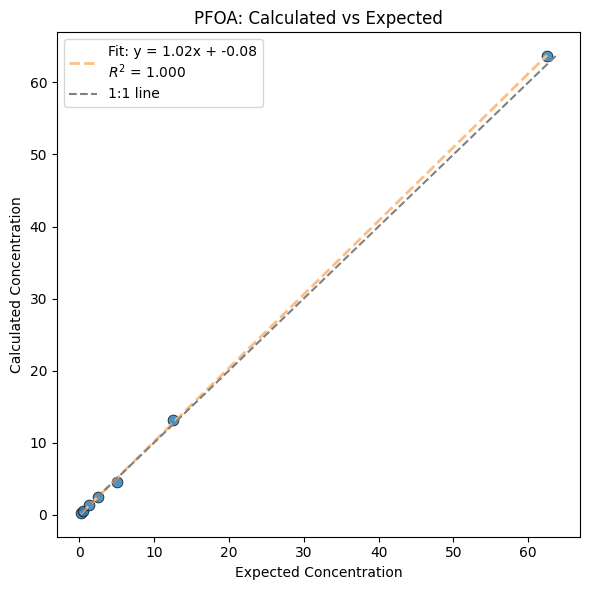

In [8]:
plot_calculated_vs_expected(conc_target_analytes_cal, expected_concs_target_analytes, analyte = "PFOA")

### 2.2.3 RSE results target analytes
We make two results, one with all calibration levels (7 for general compounds, 6 for FTS) - rse_results_cal_target, and one with the calibration level as excluded earlier for EIS compounds - rse_results_excluded_cal.

In [ ]:
%%capture
rse_results_cal_target, rse_results_excluded_cal = calculate_target_rse(conc_target_analytes_cal, expected_concs_target_analytes, p=2, level_to_exclude = excluded_cal_level )

In [ ]:
df_rse_target=df_rse_results(rse_results_cal_target)
display(df_rse_target)

In [ ]:
df_rse_target_excluded = df_rse_results(rse_results_excluded_cal) 
display(df_rse_target_excluded)

## 3 Samples 

### 3.1 Recovery EIS in Samples 
Here we compute the recovery of the EIS compounds within the samples analyzed. 

In [9]:
# computation of EIS concentration and recovery rate
from solutions import NIS_stock, EIS_stock
from allowed_recoveries import EIS_NIS_compound_recovery_aqueous

DF_sample = 1 #dilution factor 
mass_bottle_filled = 499.8 #grams
mass_bottle_empty = 53.68 #grams
Ws = (mass_bottle_filled - mass_bottle_empty)/1000 #L
#Ws_cal = 0.25 #ml

# Create weights dictionary in grams
#soils
weights_dict = {
    'Sand500': 5.0,
    'Sand504': 5.04, 
    'Sand506': 5.06, 
    'Clay537': 5.37
}

#water 23-09
weights_dict = {
    'Alex_SPE50ml_1': 49.06/1000,#541.52-56.63,
    'Alex_SPE50ml_2': 48.64/1000, # 519.73-56.00, 
    'Alex_SPE50ml_3': 47.75/1000, #541.08-57.60, 
    'Alex_SPE50ml_4': 48.82/1000, #539.58-53.62,
    'Alex_SPE50ml_Blank':49.3/1000, # 529.43-57.80
}
rawdata_copy['Ws'] = rawdata_copy['Name'].map(weights_dict)

dilution_NIS_stock = 2#1:1 dilution
#dilution_NIS_stock_cal = 40 #dilution cal
#dilution_EIS_stock_cal = 40 #dilution cal
#spiked_amount_cal = 0.05 #ml
Df_cal = 1 #dilution factor
spiked_amount_NIS = 0.01 #ml
#spiked_amount = 0.01 #ml


dilution_EIS_stock = 1
spiked_amount_EIS =0.05 #ml
#look at this! 
calculated_conc_EIS, NIS_added, EIS_added = calculate_conc_EIS(rawdata_copy, eis_RFS, dilution_NIS_stock,EIS_NIS_analogs, DF_sample, NIS_stock, spiked_amount_NIS, spiked_amount_EIS)

#for run on 12-9-2025
expected_concs_EIS_doubled = {key: 2*value for key, value in expected_concs_EIS.items()}
calculated_recoveries_EIS = calculate_recoveries(calculated_conc_EIS, expected_concs_EIS_doubled)

validation_results_samples= validate_recoveries(calculated_recoveries_EIS, EIS_NIS_compound_recovery_aqueous)
summary_samples = summarize_validation_results(validation_results_samples)
print("Validation Summary:")
for key, value in summary_samples['Overall'].items():
    print(f"{key}: {value}")

failed_recoveries_samples = get_failed_recoveries(validation_results_samples)


  - Rinse
  - Rinse
  - Rinse
  - Rinse

Calculated concentrations for 5 samples with Ws values

NIS masses added per compound:


,NIS_Compound,Mass_Added_ng
0,13C3-PFBA,5.00
1,13C2-PFHxA,2.50
2,13C4-PFOA,2.50
3,13C5-PFNA,1.25
4,13C2-PFDA,1.25
5,18O2-PFHxS,2.50
6,13C4-PFOS,2.50



EIS masses added per compound:


,EIS_Compound,Mass_Added_ng
0,D7-NMeFOSE,250.0
1,D9-NEtFOSE,250.0
2,13C4-PFBA,100.0
3,13C3-HFPO-DA,100.0
4,13C5-PFPeA,50.0
5,13C2-4:2FTS,50.0
6,13C2-6:2FTS,50.0
7,13C2-8:2FTS,50.0
8,D3-NMeFOSAA,50.0
9,D5-NEtFOSAA,50.0



Concentration results:


,Name,Type,Ws,13C5-PFHxA_Conc_Calc,13C2-PFTeDA_Conc_Calc,13C8-PFOS_Conc_Calc,13C4-PFBA_Conc_Calc,D3-NMeFOSA_Conc_Calc,13C2-8:2FTS_Conc_Calc,13C2-6:2FTS_Conc_Calc,...,D3-NMeFOSAA_Conc_Calc,13C5-PFPeA_Conc_Calc,13C2-PFDoA_Conc_Calc,D5-NEtFOSA_Conc_Calc,D7-NMeFOSE_Conc_Calc,13C3-PFHxS_Conc_Calc,13C2-4:2FTS_Conc_Calc,13C9-PFNA_Conc_Calc,D5-NEtFOSAA_Conc_Calc,13C3-PFBS_Conc_Calc
10,Alex_SPE50ml_1,Sample,0.04906,77.296501,5.619870,62.580418,356.981595,32.316130,0.107575,0.320902,...,5.668022,142.373931,23.573813,36.561820,97.007523,107.159013,0.867523,33.372112,4.473655,311.895901
11,Alex_SPE50ml_2,Sample,0.04864,85.127255,10.771617,69.387336,392.189577,36.232455,0.267143,0.328860,...,6.367412,153.503784,24.216248,39.116172,94.841091,120.934286,1.067747,41.606779,4.517887,345.501659
12,Alex_SPE50ml_3,Sample,0.04775,96.211416,8.815928,76.357092,448.260235,39.693352,0.314875,0.445109,...,7.689100,178.330213,27.988680,42.424616,105.035531,132.640856,1.168671,51.275991,5.257648,404.010592
13,Alex_SPE50ml_4,Sample,0.04882,95.644845,6.922280,79.421422,433.949244,40.492704,0.295110,0.355821,...,7.897348,180.928393,32.827485,43.996205,107.101673,130.643346,1.049889,43.519587,5.440959,369.586235
14,Alex_SPE50ml_Blank,Sample,0.04930,110.676295,6.426623,88.489135,502.153465,43.763523,0.341621,0.429662,...,7.289641,202.297154,28.780513,44.634364,109.859775,154.990037,1.671400,51.084816,5.663977,478.882666


,Name,Type,D7-NMeFOSE_Recovery_%,D9-NEtFOSE_Recovery_%,13C4-PFBA_Recovery_%,13C3-HFPO-DA_Recovery_%,13C5-PFPeA_Recovery_%,13C2-4:2FTS_Recovery_%,13C2-6:2FTS_Recovery_%,13C2-8:2FTS_Recovery_%,...,13C3-PFHxS_Recovery_%,13C8-PFOS_Recovery_%,13C8-PFOSA_Recovery_%,D3-NMeFOSA_Recovery_%,D5-NEtFOSA_Recovery_%,13C9-PFNA_Recovery_%,13C6-PFDA_Recovery_%,13C7-PFUnA_Recovery_%,13C2-PFDoA_Recovery_%,13C2-PFTeDA_Recovery_%
10,Alex_SPE50ml_1,Sample,194.015046,234.587303,1784.907973,347.922880,1423.739312,8.675229,3.209024,1.075754,...,2143.180268,1251.608352,13571.114384,646.322594,731.236395,1334.884490,6162.295602,2294.437902,942.952507,224.794815
11,Alex_SPE50ml_2,Sample,189.682181,218.736664,1960.947886,388.355594,1535.037839,10.677469,3.288605,2.671431,...,2418.685716,1387.746711,14476.258296,724.649099,782.323446,1664.271159,6601.053042,2803.918188,968.649917,430.864681
12,Alex_SPE50ml_3,Sample,210.071061,250.713010,2241.301177,424.818713,1783.302132,11.686709,4.451092,3.148754,...,2652.817116,1527.141830,16619.053983,793.867038,848.492321,2051.039655,7145.493137,3088.004205,1119.547191,352.637140
13,Alex_SPE50ml_4,Sample,214.203345,249.268341,2169.746218,424.186746,1809.283932,10.498893,3.558211,2.951104,...,2612.866913,1588.428431,16615.622013,809.854077,879.924104,1740.783489,7335.768956,2633.963730,1313.099392,276.891189
14,Alex_SPE50ml_Blank,Sample,219.719551,249.482817,2510.767325,486.134709,2022.971539,16.713996,4.296623,3.416209,...,3099.800740,1769.782705,17885.715185,875.270453,892.687277,2043.392621,9246.340989,3394.309555,1151.220531,257.064927


Validation Summary:
Total_Measurements: 120
Passed: 10
Failed: 105
No_Data: 0
No_Reference: 5
Pass_Rate_%: 8.695652173913043


,Sample_Name,Sample_Type,Compound,Calculated_Recovery_%,Expected_Lower_%,Expected_Upper_%,Status,Compound_Type
0,Alex_SPE50ml_1,Sample,D7-NMeFOSE,194.015046,10.0,130.0,Fail,EIS
1,Alex_SPE50ml_1,Sample,D9-NEtFOSE,234.587303,10.0,130.0,Fail,EIS
2,Alex_SPE50ml_1,Sample,13C4-PFBA,1784.907973,5.0,130.0,Fail,EIS
4,Alex_SPE50ml_1,Sample,13C5-PFPeA,1423.739312,40.0,130.0,Fail,EIS
5,Alex_SPE50ml_1,Sample,13C2-4:2FTS,8.675229,40.0,200.0,Fail,EIS
...,...,...,...,...,...,...,...,...
115,Alex_SPE50ml_Blank,Sample,13C9-PFNA,2043.392621,40.0,130.0,Fail,EIS
116,Alex_SPE50ml_Blank,Sample,13C6-PFDA,9246.340989,40.0,130.0,Fail,EIS
117,Alex_SPE50ml_Blank,Sample,13C7-PFUnA,3394.309555,30.0,130.0,Fail,EIS
118,Alex_SPE50ml_Blank,Sample,13C2-PFDoA,1151.220531,10.0,130.0,Fail,EIS


## 3.2 QC samples
In this section we will check the results of the QC samples and assessing if they meet recovery limits. We have already computed EIS recovery for QC earlier. Here, we also compute the concentration for the target analytes in the QC samples.

In [ ]:
sample_QC = "QC"
QC_level = 5
conc_target_analytes_QC = calculate_conc_targets(rawdata_copy,
                           RF_target_analytes,
                           EIS_stock, dilution_EIS_stock_cal, spiked_amount_cal, Ws_cal,
                           Df_cal, sample_QC, debug_compound=None )

calculated_recoveries_EIS_QC = calculate_recoveries(conc_QC, expected_concs_EIS)
expected_concs_level =  filter_expected_concs_by_level(expected_concs_target_analytes,QC_level)
calculated_recoveries_target_QC = calculate_recoveries(conc_target_analytes_QC, expected_concs_level)

validation_results_target_QC= validate_recoveries(calculated_recoveries_target_QC, OPR_recovery_solid)

summary_cal = summarize_validation_results(validation_results_cal)
print("Validation Summary:")
for key, value in summary_cal['Overall'].items():
    print(f"{key}: {value}")

failed_recoveries_cal = get_failed_recoveries(validation_results_cal)
